## 필요한 라이브러리 및 데이터 가져오기

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [17]:
# fix seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

## 컬럼 명

<font size="4">person_age : 나이</font>  
<font size="4">person_income : 개인 소득</font>  
<font size="4">person_home_ownership : 개인 집 소유권</font>  
<font size="4">person_emp_length : 개인이 현재 직장에서 근무한 기간</font>  
<font size="4">loan_intent : 대출 목적</font>  
<font size="4">loan_grade : 대출 등급</font>  
<font size="4">loan_amnt : 대출 금액</font>  
<font size="4">loan_int_rate : 대출 금리 (대출 금액에 대해 지불해야할 이자율)</font>  
<font size="4">loan_percent_income : 대출 소득 퍼센트 ( 대출 금액이 개인의 소득에서 차지하는 비율)</font>  
<font size="4">cb_person_default_on_file : 신용 기록에 대한 연체나 채무 불이행 여부</font>  
<font size="4">cb_person_cred_hist_length : 개인이 신용 기록을 보유한 기간</font>  
<font size="4">loan_status : 대출 승인 여부 (label)</font>  


## EDA

In [4]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [6]:
loan = df_train.copy()
loan.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [8]:
loan['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [6]:
loan.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [7]:
loan_num = loan.select_dtypes(include=['number'])
loan_num.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,0,37,35000,0.0,6000,11.49,0.17,14,0
1,1,22,56000,6.0,4000,13.35,0.07,2,0
2,2,29,28800,8.0,6000,8.90,0.21,10,0
3,3,30,70000,14.0,12000,11.11,0.17,5,0
4,4,22,60000,2.0,6000,6.92,0.10,3,0


In [8]:
loan_num = loan_num.drop(columns='id')

In [9]:
loan_ob = loan.select_dtypes(include=['object'])
loan_ob.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N
2,OWN,PERSONAL,A,N
3,RENT,VENTURE,B,N
4,RENT,MEDICAL,A,N


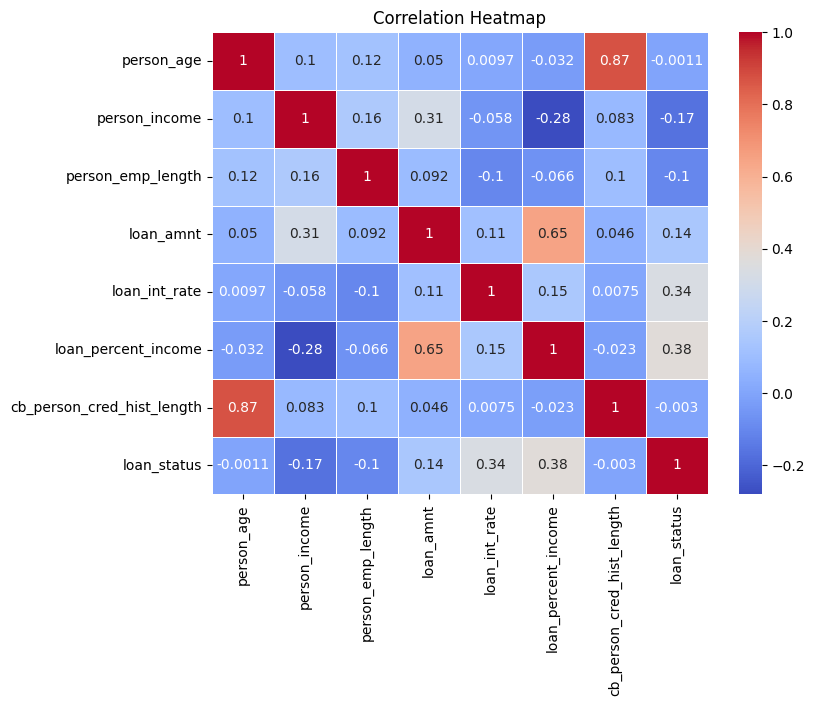

In [10]:
corr = loan_num.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

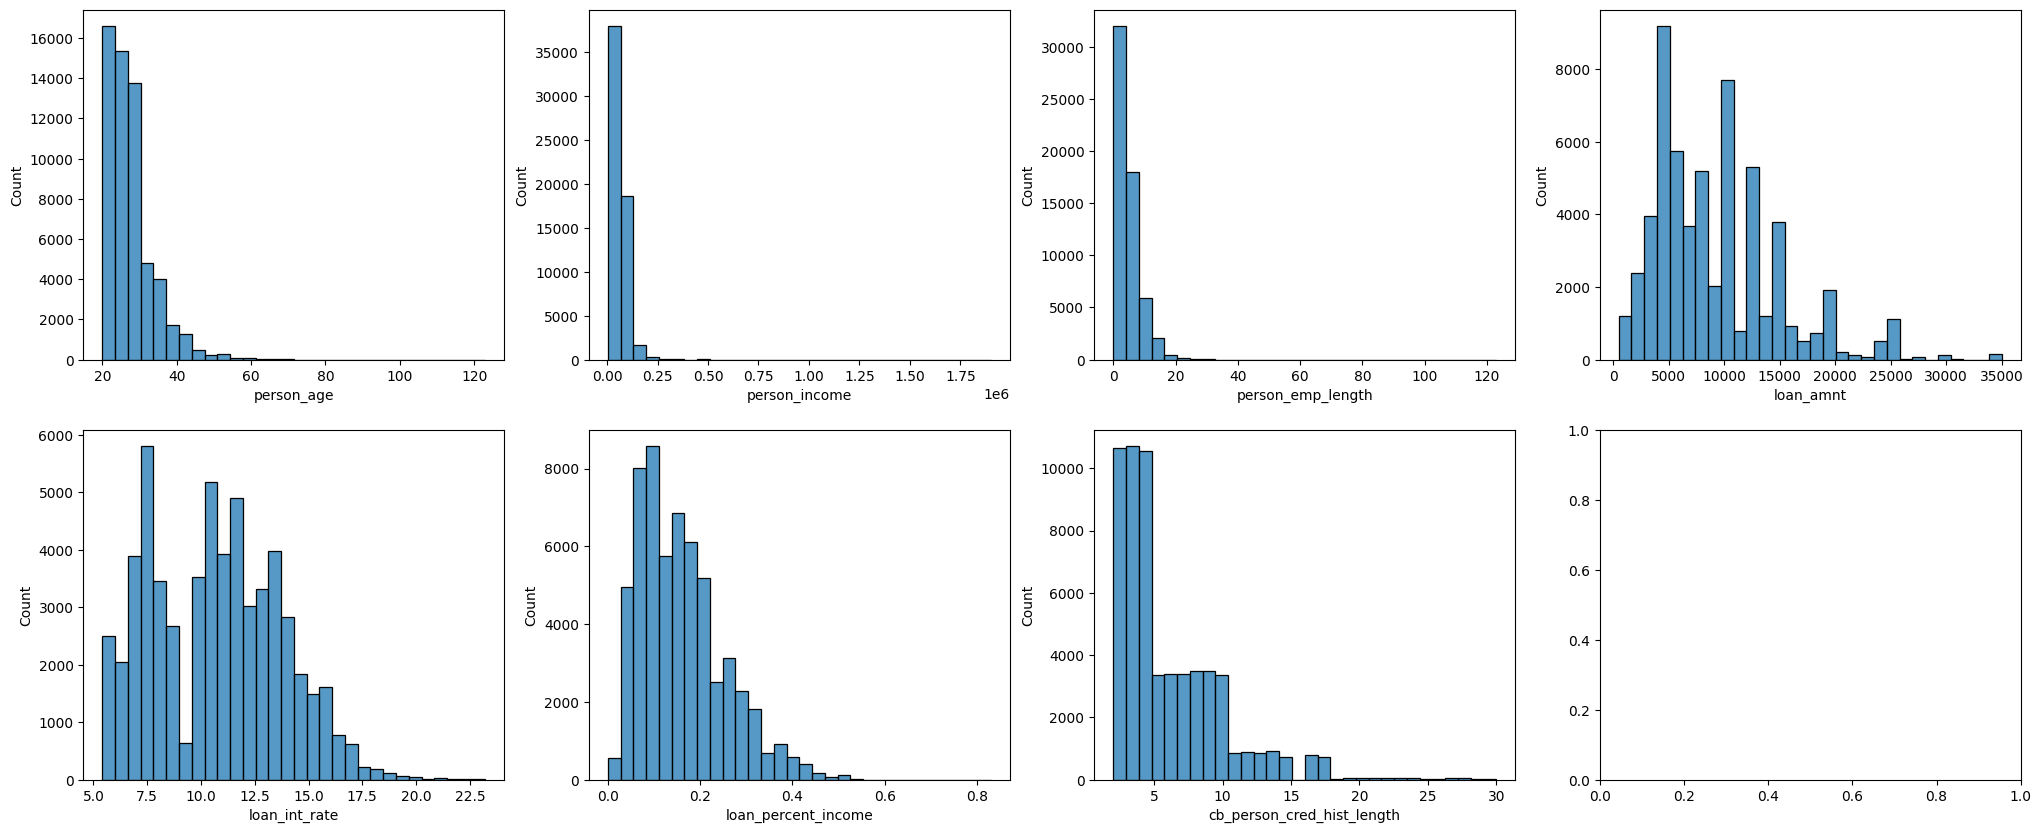

In [11]:
cols = loan_num.columns.drop('loan_status')
fig, ax = plt.subplots(2,4, figsize=(25, 10))
for i, v in enumerate(cols):
    row = i //4
    col = i % 4
    sns.histplot(x=v, data = loan_num, bins= 30,ax=ax[row,col])
plt.show()

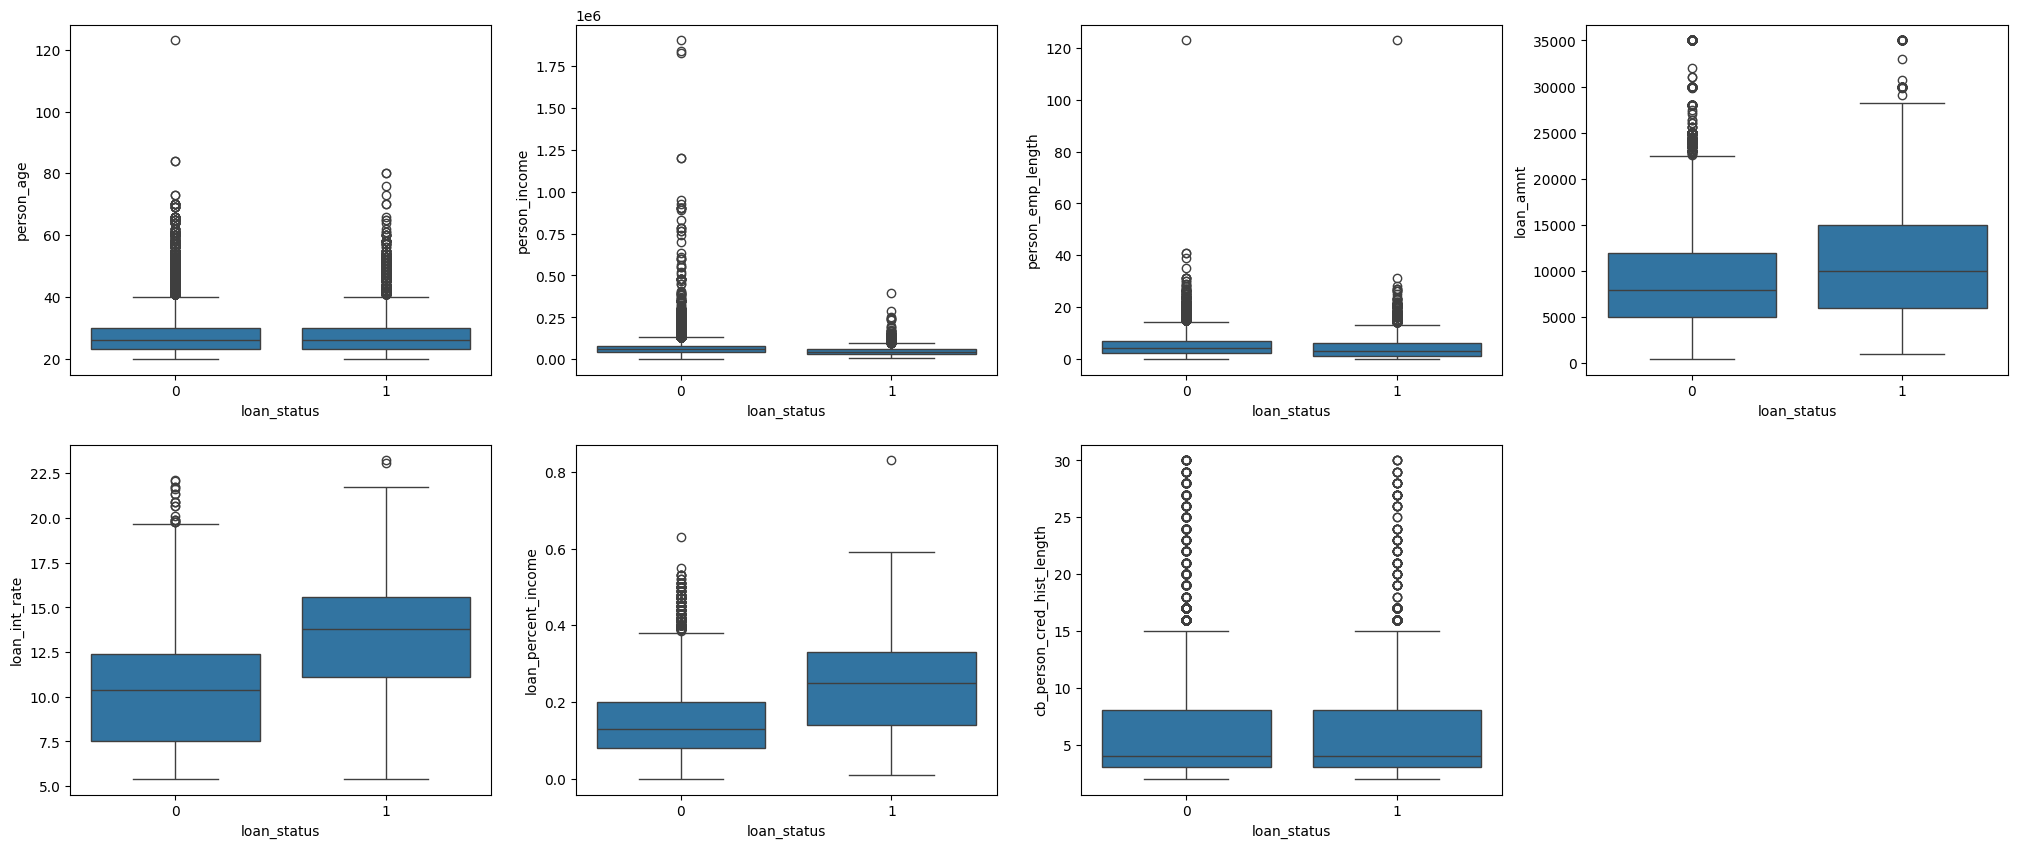

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
for i, v in enumerate(cols):
    row = i // 4  
    col = i % 4 
    sns.boxplot(x='loan_status', y=v, data=loan_num, ax=ax[row, col])
fig.delaxes(ax[1, 3])
plt.show()

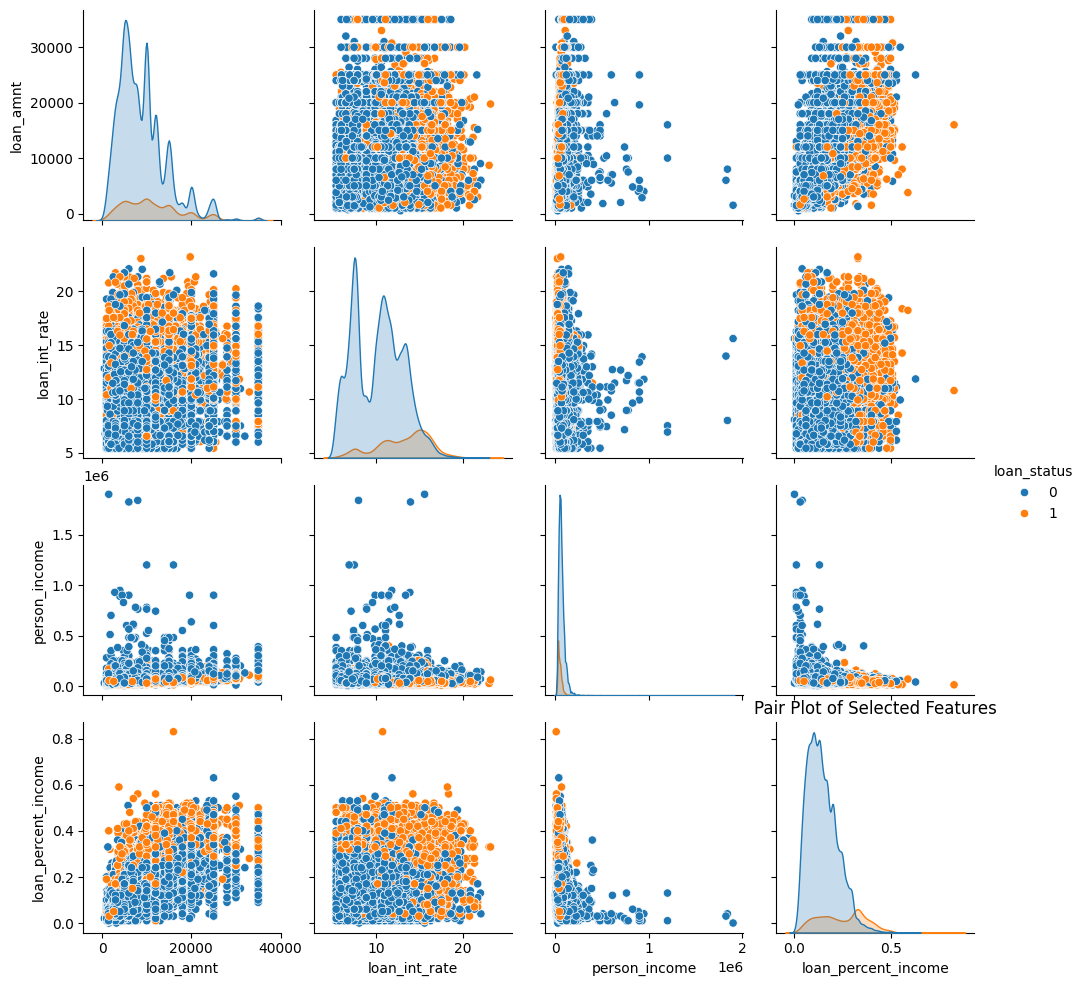

In [19]:
subset_features = ['loan_amnt', 'loan_int_rate', 'person_income', 'loan_percent_income', 'loan_status']
sns.pairplot(loan[subset_features], hue='loan_status')
plt.title('Pair Plot of Selected Features')
plt.show()

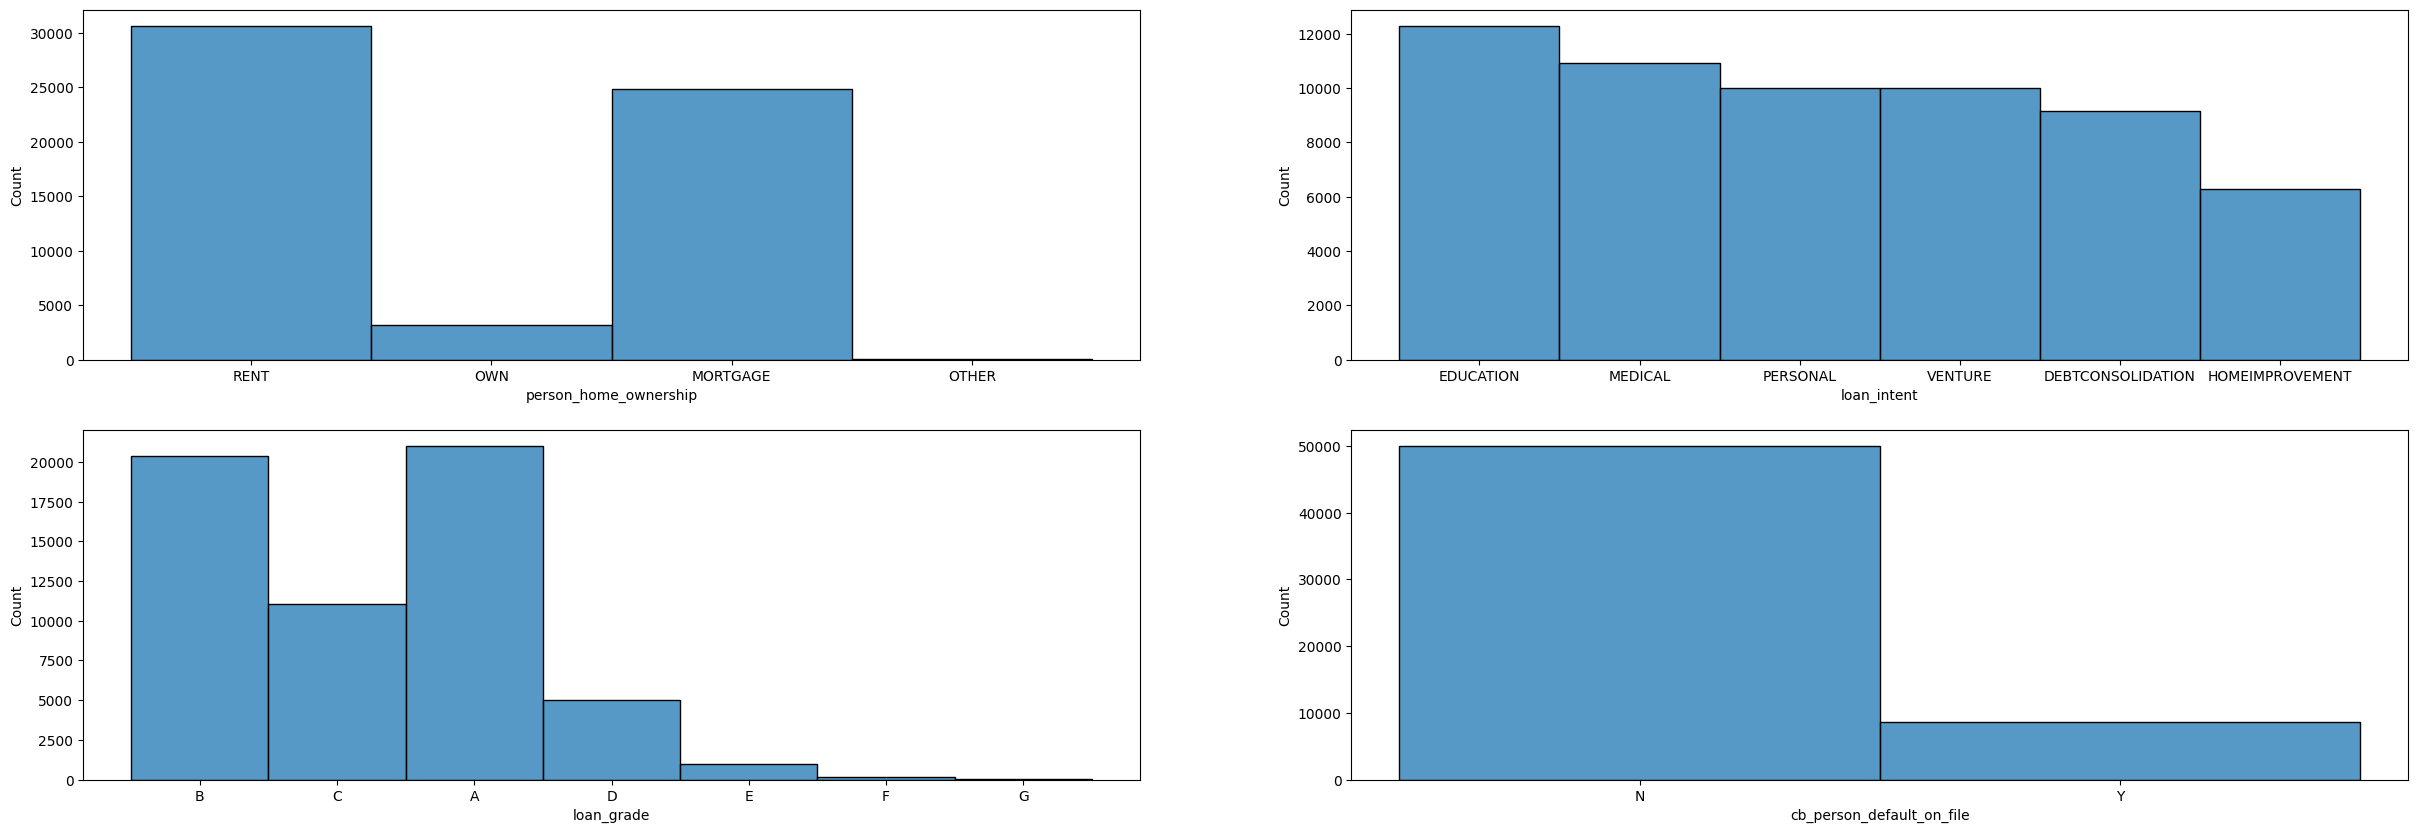

In [13]:
colsob = loan_ob.columns
fig, ax = plt.subplots(2,2, figsize=(30, 10))
for i, v in enumerate(colsob):
    row = i //2
    col = i % 2
    sns.histplot(x=v, data = loan_ob, ax=ax[row,col])
plt.show()

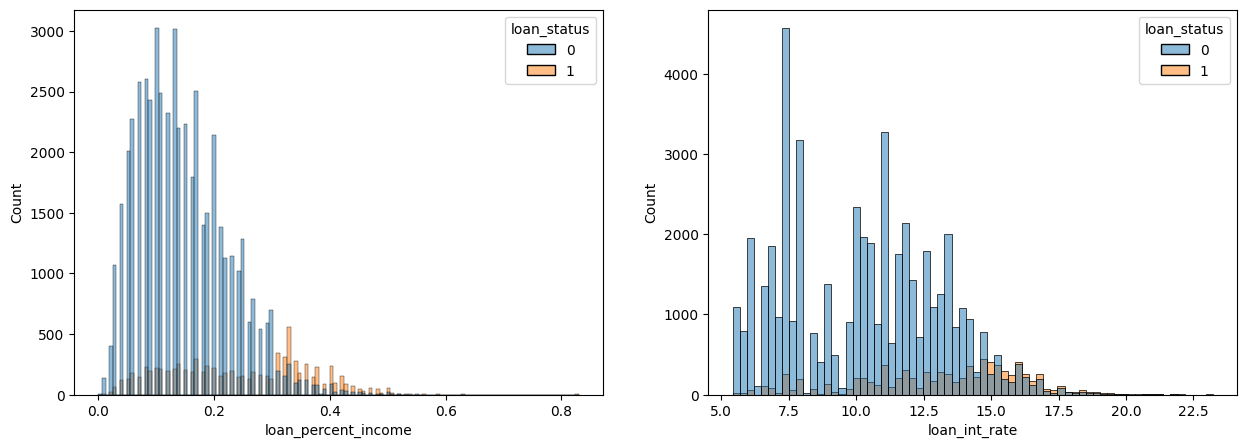

In [14]:
# yes_data = loan_num[loan_num['loan_status'] == 1]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x='loan_percent_income', data=loan_num, hue='loan_status', ax=ax[0])
sns.histplot(x='loan_int_rate', data=loan_num, hue='loan_status', ax=ax[1])
plt.show()

## loan_grade, person_home_ownership, loan_intent, person_home_ownership

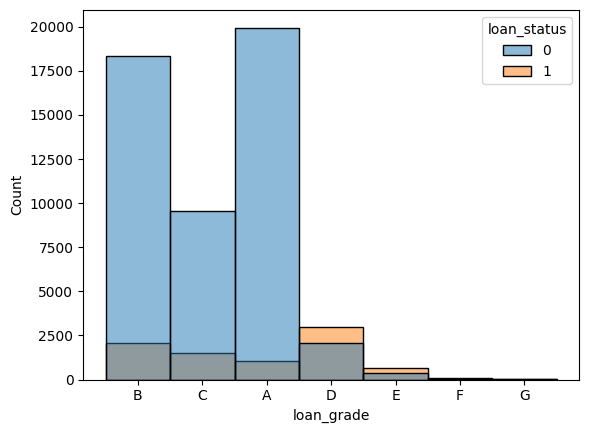

In [15]:
sns.histplot(x='loan_grade', data=loan, hue='loan_status')
plt.show()

- 대출등급이 높다고 대출승인이 나는 것은 아닌것 같음.
- 오히러 낮은 대출등급에서 대출승인이 나는 비율이 높음.

  => 대출등급이 낮은 것과 높은 것 두 분류로 나눠 분석 진행

In [16]:
loan['loan_grade'] = loan['loan_grade'].replace({'D': 'low', 'E': 'low', 'F': 'low', 'G': 'low'})
loan['loan_grade'] = loan['loan_grade'].replace({'A': 'high', 'B': 'high', 'C': 'high'})

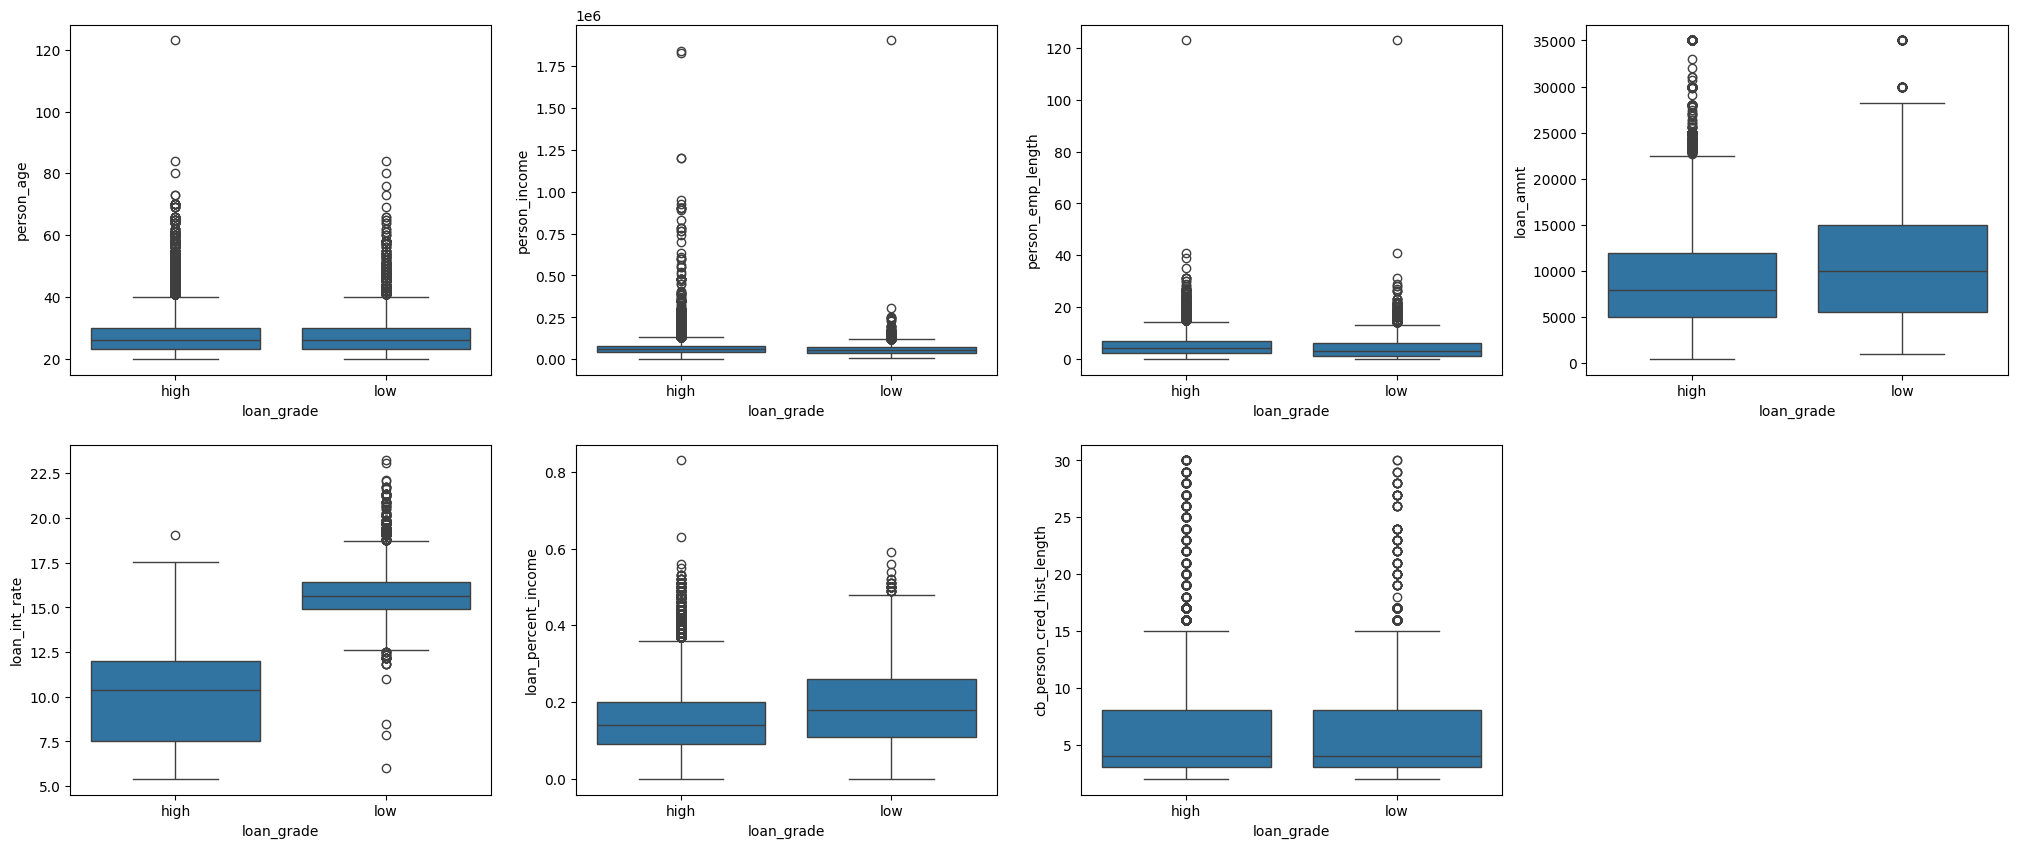

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
for i, v in enumerate(cols):
    row = i // 4  
    col = i % 4 
    sns.boxplot(x='loan_grade', y=v, data=loan, ax=ax[row, col])
fig.delaxes(ax[1, 3])
plt.show()

In [18]:
default_cnt = loan.groupby('loan_grade')['cb_person_default_on_file'].value_counts().unstack()
default_cnt

cb_person_default_on_file,N,Y
loan_grade,,
high,46897,5523
low,3046,3179


In [24]:
grade_income = loan.groupby('loan_grade')[['loan_amnt', 'person_income']].mean().reset_index()
grade_income

,loan_grade,loan_amnt,person_income
0,high,9023.005189,64597.163220
1,low,10855.850602,59406.347309


- 대출등급이 낮은 사람들이 대출 승인 비율이 높음.
- 대출등급이 높은 사람들에 비해 낮은 사람들의 loan_int_rate가 높게나옴.
- 대출등급이 낮은 사람들은 채무 불이행 기록으로 인해 loan_int_rate의 값이 더 크게나옴.
- 대출등급이 낮은 사람들은 자신의 수익에 비해 대출금액이 큼.
  
  => loan_int_rate, loan_percent_income과 대출승인과의 양의 상관 관계가 나타나는 이유.

- 은행은 리스크를 감수하고 더많은 이자를 받기 위해 대출 등급이 낮은 사람들에 대해서 대출 승인을 해주는 것을 보임.

<Axes: xlabel='person_home_ownership', ylabel='Count'>

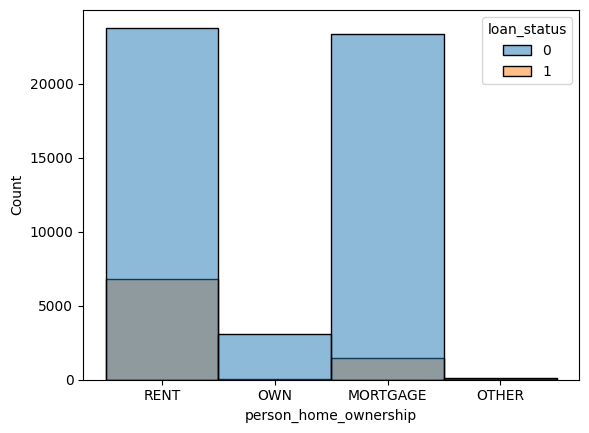

In [100]:
sns.histplot(x='person_home_ownership', hue='loan_status', data=loan)

- RENT, MORTGAGE인 경우에 주로 대출 승인이 일어남.

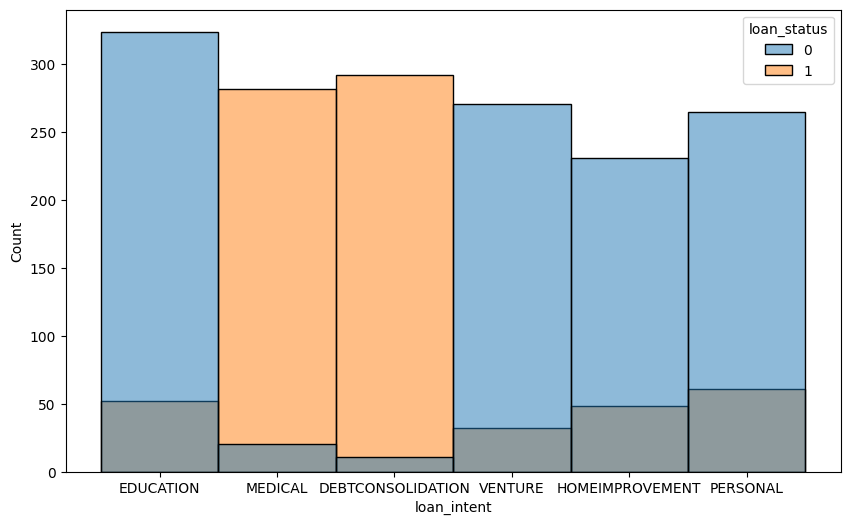

In [109]:
filtered_loan = loan[
    (loan['loan_grade'] == 'low') & 
    (loan['person_home_ownership'].isin(['RNET', 'MORTGAGE']))
]
plt.figure(figsize=(10,6))
sns.histplot(x='loan_intent', hue='loan_status', data=filtered_loan)
plt.show()

- 대출등급이 낮은 사람, 집 소유권 상태가 RENT, MORTGAGE인 사람들의 대출 목적을 분석한 결과, 의학 목적 혹은 부채 통합 대출 목적인 경우 대출 승인이 많이 일어남

## 모델 성능 비교

In [19]:
# train 데이터를 train과 valid 데이터로 분할
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("loan_status", axis=1),
    df_train["loan_status"],
    test_size=0.2, # 비율 train : valid = 8 : 2
    shuffle=True, # 데이터의 class가 편중되는 것을 방지 
    random_state=SEED,
    stratify = df_train["loan_status"] # train/valid 데이터의 class 비율을 동일하게
)

In [44]:
def get_clf_eval(y_test, y_pred=None):
    # True와 False 레이블을 명시적으로 지정하여 오차 행렬을 생성합니다.
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    # 정확도 계산: 전체 중에서 올바르게 예측된 비율
    accuracy = accuracy_score(y_test, y_pred)
    # 정밀도 계산: True로 예측된 것 중 실제 True의 비율
    precision = precision_score(y_test, y_pred, labels=[True, False])
    # 재현율 계산: 실제 True 중에서 True로 올바르게 예측된 비율
    recall = recall_score(y_test, y_pred)
    # F1 점수 계산: 정밀도와 재현율의 조화 평균
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    # 성능 지표 출력
    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46916 entries, 18548 to 22774
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          46916 non-null  int64  
 1   person_age                  46916 non-null  int64  
 2   person_income               46916 non-null  int64  
 3   person_home_ownership       46916 non-null  object 
 4   person_emp_length           46916 non-null  float64
 5   loan_intent                 46916 non-null  object 
 6   loan_grade                  46916 non-null  object 
 7   loan_amnt                   46916 non-null  int64  
 8   loan_int_rate               46916 non-null  float64
 9   loan_percent_income         46916 non-null  float64
 10  cb_person_default_on_file   46916 non-null  object 
 11  cb_person_cred_hist_length  46916 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 4.7+ MB


In [21]:
object_cols = ['person_home_ownership', 'loan_intent',
               'loan_grade', 'cb_person_default_on_file']

In [22]:
def object2category(df):
    for i in df.columns:
        if i in object_cols:
            df[[i]] = df[[i]].astype('category')
        elif df[i].dtype == 'object':
            df[[i]] = df[[i]].astype('category')
    return df

x_train = object2category(x_train)
x_val = object2category(x_val)
x_test = object2category(df_test)

In [24]:
# category type 컬럼 인덱스 저장
categorical_features = []
for i, col in enumerate(x_train.columns):
    if x_train[col].dtypes=='category':
        categorical_features.append(i)

In [29]:
lgb_model = lgb.LGBMClassifier(random_state=SEED, 
                               categorical_feature = categorical_features)
cbt_model = CatBoostClassifier(random_state=SEED, 
                               cat_features = categorical_features)
xgb_model = XGBClassifier(random_state=SEED, enable_categorical=True)

In [30]:
lgb_model.fit(x_train, y_train)
cbt_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)

C:\Users\carra\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] categorical_feature is set=3,5,6,10, categorical_column=3,5,6,10 will be ignored. Current value: categorical_feature=3,5,6,10
[LightGBM] [Info] Number of positive: 6680, number of negative: 40236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644
Learning rate set to 0.053283
0:	learn: 0.6296842	total: 74.5ms	remaining: 1m 14s
1:	learn: 0.5713279	total: 158ms	remaining: 1m 18s
2:	learn: 0.5244583	total: 251ms	remaining: 1m 23s
3:	learn: 0.4815584	total: 336ms	remaining: 1m 23s
4:	learn: 0.4469914	total: 403ms	remaining: 1m 20s
5:	learn: 0.4153939	total: 475ms	remaining: 1m 18s
6:	learn: 0.3884340	tot

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [34]:
lgb_preds = lgb_model.predict(x_val)
cbt_preds = cbt_model.predict(x_val)
xgb_preds = xgb_model.predict(x_val)

In [43]:
y_val_lgb_pred = np.where(lgb_preds>=0.5, 1, 0)
y_val_cbt_pred = np.where(cbt_preds>=0.5, 1, 0)
y_val_xgb_pred = np.where(xgb_preds>=0.5, 1, 0)

print('LightGBM')
get_clf_eval(y_val, y_val_lgb_pred)
print('\n')
print('Catboost')
get_clf_eval(y_val, y_val_cbt_pred)
print('\n')
print('XGBoost')
get_clf_eval(y_val, y_val_xgb_pred)

LightGBM
오차행렬:
 [[1198  472]
 [  98 9961]]

정확도: 0.9514
정밀도: 0.9244
재현율: 0.7174
F1: 0.8078


Catboost
오차행렬:
 [[1219  451]
 [ 109 9950]]

정확도: 0.9523
정밀도: 0.9179
재현율: 0.7299
F1: 0.8132


XGBoost
오차행렬:
 [[1216  454]
 [ 125 9934]]

정확도: 0.9506
정밀도: 0.9068
재현율: 0.7281
F1: 0.8077
